# TIMESERIES FORECASTING - Autoregressive Integrated Moving Average (ARIMA)


## Install and import libraries
---
This exercise requires the `pdarima` library, which can be installed with Python's `pip` command. This command only needs to be done once per machine.

The standard, shorter approach may work:

In [1]:
# pip install pmdarima --user

If the above command didn't work, it may be necessary to be more explicit, in which case you could run the code below.

In [2]:
# import sys
# !{sys.executable} -m pip install pmdarima --user

Once `pdarima` is installed, then load the libraries below.

In [20]:
import pandas as pd
import numpy as np
from scipy import stats                                 # needed for z-score
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

## Load and prepare data
---

In [86]:
df = pd.read_csv('../datasets/airpassengers.csv', parse_dates=['Month'], index_col=['Month'])

## Plot data
---

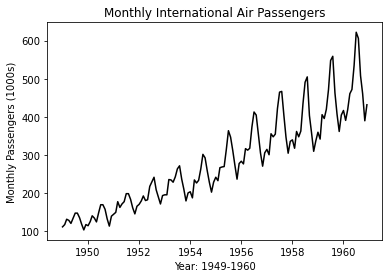

In [60]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly International Air Passengers')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## Split data into train and test set
---

- Our goal is to predict future values in the time series.
- To do this, we'll use data from 1949 through 1957 for training the model.
- We'll then use data from 1958 through 1960 for testing the predictions.

### Create Training Dataset

In [23]:
# Select data from before 1958.

train = df.loc[df.index < '1958-01-01']


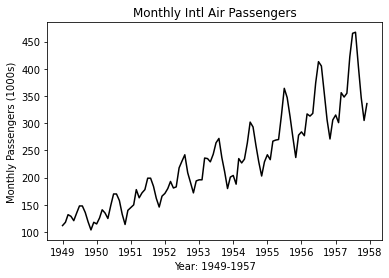

In [24]:
# Plot the training data

fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly International Air Passengers')
plt.plot(train, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### Create Testing Dataset

In [25]:
# Use data from 1958 through 1960 (the last three years) for testing.

test = df.loc[df.index >= '1958-01-01']

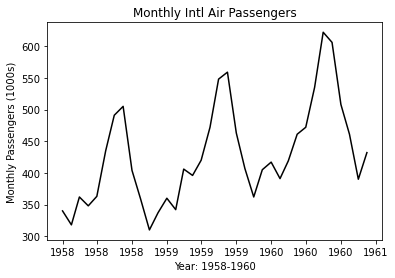

In [26]:
# Plot the testing data.
# Note that the vertical scale changes from the previous graph.

fig, ax = plt.subplots()
plt.xlabel('Year: 1958-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly InInternational Air Passengers')
plt.plot(test, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## Prepare the model
---

### Test Stationarity
ARIMA requires non-stationary data. That is, ARIMA needs data where the mean, the variance, and/or the covariance vary over time. Non-stationary data shows significant correlations when lagged. A "correlogram" graph (or ACF plot) shows the degree of correlation at different values of lag. Ideally, none of the lag values will fall in the range of nonsignificant correlations.

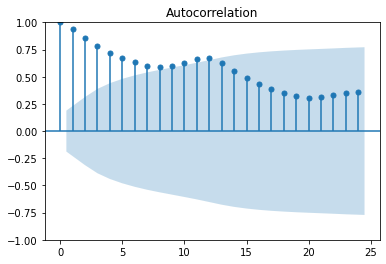

In [27]:
train_acf = plot_acf(train, lags=24)

### Linear Model

- Fit a linear regression model to serve as a baseline. 
- The dependent variable is the number of passengers. 
- The independent variable is a linear time trend, including a constant (or intercept).

In [79]:
lr = sm.OLS(endog=train['#Passengers'], exog=sm.add_constant(np.arange(1, 1 + train.shape[0]))).fit() 
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Thu, 20 Apr 2023   Prob (F-statistic):           6.40e-43
Time:                        11:57:25   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

In [29]:
# Extract the fitted values.
y_hat = lr.fittedvalues

In [30]:
# Extract the 95% prediction interval.
y_ci = lr.get_prediction().conf_int(alpha=0.05)

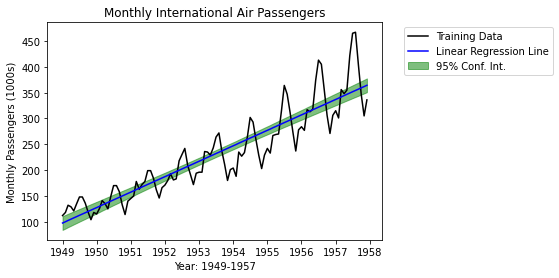

In [61]:
# Graph time series with linear regression line and corresponding 95% confidence interval.
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly International Air Passengers')
plt.plot(train, color='black', label='Training Data')
plt.plot(y_hat, color='blue', label='Linear Regression Line')
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='green', alpha=0.5, label='95% Conf. Int.')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## ARIMA: Train model
---

Find the best ARIMA order using the `auto_arima` function in the `pmdarima` package. Note that the `auto_arima` function assumes that the time series is non-seasonal by default (i.e. the seasonal period "m" is set equal to 1 by default). In what follows we set "m" equal to 12 to ensure that the selected optimal model takes into account the annual seasonality observed in the time series (one cycle every 12 months).    

Note: We are actually conducting a variation on ARIMA called "SARIMAX," or "Seasonal Auto-Regressive Integrated Moving Average with Exogenous Factors."

In [32]:
auto_arima_model = auto_arima(train, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Thu, 20 Apr 2023   AIC                            704.001
Time:                                    07:04:05   BIC                            709.109
Sample:                                01-01-1949   HQIC                           706.065
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

- The `auto_arima` function suggests `ARIMA(1,1,0)(0,1,0,12)`.    

First set of numbers is for the basic, non-seasonal model    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # p: Auto-regressive (AR) order   
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # d: Integrate (I), or degree of differencing   
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # q: Moving average (MA) order   

In [33]:
auto_arima_model.order

(1, 1, 0)

Second set of numbers is for seasonality    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # P: Auto-regressive (AR) order    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # D: Integrate (I), or degree of differencing    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # Q: Moving average (MA) order   
&nbsp;  12 &nbsp;  # M: Model period or seasonality   

In [34]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

In [35]:
# Extract the residuals. 
resid = auto_arima_model.resid()

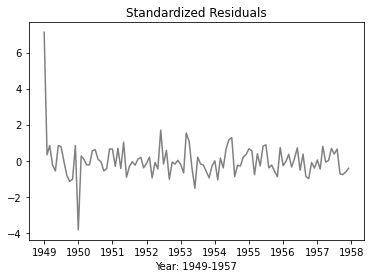

In [36]:
# Plot the standardized residuals.
fig, ax = plt.subplots()
plt.plot(train.index, stats.zscore(resid), color='gray') 
plt.title('Standardized Residuals')
plt.xlabel('Year: 1949-1957')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

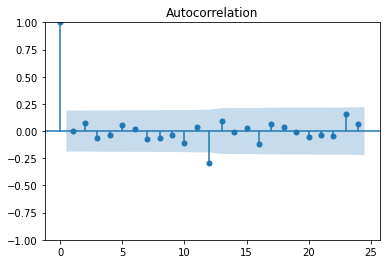

In [37]:
# Plot the ACF (autocorrelation function) of the residuals. 
res_acf = plot_acf(resid, lags=24)

## Test the model
---

In [40]:
# Fit the best model to the training data.
auto_arima_model.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [41]:
# Use the model to predict intervals for last three years.
# That is, apply the model to the testing dataset.
arima_predictions = auto_arima_model.predict(n_periods=36, alpha=0.05, return_conf_int=True)

In [88]:
# Extract the time series of model predictions.
y_pred = pd.Series(arima_predictions[0], index=test.index)


In [43]:
# Extract the 95% prediction interval.
y_pred_lb, y_pred_ub = arima_predictions[1][:, 0], arima_predictions[1][:, 1]

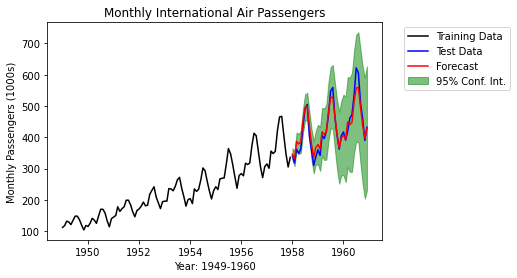

In [63]:
# Graph the training data (1949-1957).
# Add the predictions for the testing data (1958-1960).
# Add observed values from testing data.

fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly International Air Passengers')
plt.fill_between(test.index, y_pred_lb, y_pred_ub, color='green', alpha=0.5, label='95% Conf. Int.')
plt.plot(train, color='black', label='Training Data')
plt.plot(test, color='blue', label='Test Data')
plt.plot(y_pred, color='red', label='Forecast')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [76]:
# Create a dataframe with the observed values for the testing dataset.
# Add the predictions from the ARIMA model.
# Add the low and high boundaries for the 95% confidence intervals.

test_pred = pd.DataFrame({
    'Actual': test.iloc[:, 0].values, 
    'Point Forecast': y_pred.values, 
    'Lo 95': y_pred_lb,
    'Hi 95': y_pred_ub
    }, index=test.index)

In [77]:
test_pred.head()

,Actual,Point Forecast,Lo 95,Hi 95
Month,,,,
1958-01-01,340,345.964471,327.088699,364.840243
1958-02-01,318,331.731920,308.036230,355.427610
1958-03-01,362,386.787992,358.515741,415.060243
1958-04-01,348,378.774472,346.695455,410.853490
1958-05-01,363,385.777732,350.270765,421.284699
